In [16]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Denoising Diffusion Probabilistic Models with MedNIST Dataset

This tutorial illustrates how to use MONAI for training a denoising diffusion probabilistic model (DDPM)[1] to create
synthetic 2D images.

[1] - Ho et al. "Denoising Diffusion Probabilistic Models" https://arxiv.org/abs/2006.11239


## Setup environment

In [17]:
# !python -c "import monai" || pip install -q "monai-weekly[tqdm]"
# !python -c "import matplotlib" || pip install -q matplotlib
# %matplotlib inline

## Setup imports

In [18]:
%cd /workspace

/workspace


In [19]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.1.0
Numpy version: 1.22.2
Pytorch version: 2.1.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.1
gdown version: 4.6.0
TorchVision version: 0.14.0a0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.2
pandas version: 1.4.4
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.0.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.

This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [20]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp4ygbnbjv


## Set deterministic training for reproducibility

In [21]:
set_determinism(42)

## Setup MedNIST Dataset and training and validation dataloaders
In this tutorial, we will train our models on the MedNIST dataset available on MONAI
(https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset). In order to train faster, we will select just
one of the available classes ("Hand"), resulting in a training set with 7999 2D images.

In [22]:
# train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, progress=False, seed=0)
# train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]

In [23]:
from glob import glob
train_datalist = [{"image": item} for item in sorted(glob('data/*')[:])]
train_datalist

[{'image': 'data/img000000.png'},
 {'image': 'data/img000001.png'},
 {'image': 'data/img000002.png'},
 {'image': 'data/img000003.png'},
 {'image': 'data/img000004.png'},
 {'image': 'data/img000005.png'},
 {'image': 'data/img000007.png'},
 {'image': 'data/img000008.png'},
 {'image': 'data/img000009.png'},
 {'image': 'data/img000011.png'},
 {'image': 'data/img000012.png'},
 {'image': 'data/img000015.png'},
 {'image': 'data/img000018.png'},
 {'image': 'data/img000019.png'},
 {'image': 'data/img000021.png'},
 {'image': 'data/img000022.png'},
 {'image': 'data/img000023.png'},
 {'image': 'data/img000024.png'},
 {'image': 'data/img000025.png'},
 {'image': 'data/img000026.png'},
 {'image': 'data/img000028.png'},
 {'image': 'data/img000029.png'},
 {'image': 'data/img000030.png'},
 {'image': 'data/img000031.png'},
 {'image': 'data/img000032.png'},
 {'image': 'data/img000033.png'},
 {'image': 'data/img000034.png'},
 {'image': 'data/img000035.png'},
 {'image': 'data/img000036.png'},
 {'image': 'da

Here we use transforms to augment the training dataset:

1. `LoadImaged` loads the hands images from files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].
1. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.

In [24]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.Resized(keys=["image"], spatial_size=(128,128)),
        transforms.RandAffined(
            keys=["image"],
            # rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            # scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            # spatial_size=[64, 64],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=40, shuffle=True, num_workers=10, persistent_workers=True)

Loading dataset: 100%|██████████| 700/700 [00:01<00:00, 377.68it/s]


In [25]:
# val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, progress=False, seed=0)
# val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_datalist = [{"image": item} for item in sorted(glob('data/*')[-100:])]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.Resized(keys=["image"], spatial_size=(128,128)),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=30, shuffle=False, num_workers=10, persistent_workers=True)

Loading dataset: 100%|██████████| 100/100 [00:00<00:00, 412.63it/s]


### Visualisation of the training images

batch shape: torch.Size([40, 1, 128, 128])


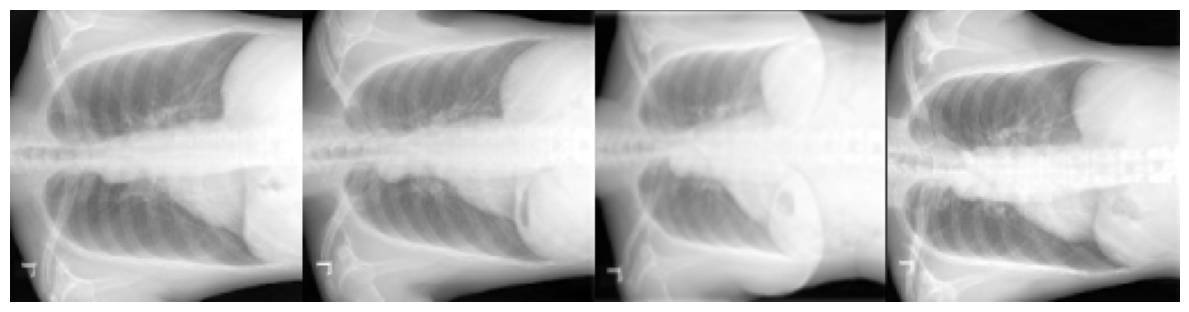

In [26]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    [check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

### Define network, scheduler, optimizer, and inferer
At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using
the original DDPM scheduler containing 1000 timesteps in its Markov chain, and a 2D UNET with attention mechanisms
in the 2nd and 3rd levels, each with 1 attention head.

In [27]:
device = torch.device("cuda:2")
#224*224 -> 112*112 -> 56*56 -> 28*28 -> 14*14 -> 7*7
#128*128 -> 64*64 -> 32*32 -> 16*16 -> 8*
model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 128, 256, 256),
    use_flash_attention=True,
    attention_levels=(False, False, True, True),
    num_res_blocks=2,
    num_head_channels=(0,0,32,32),
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

### Model training
Here, we are training our model for 75 epochs (training time: ~50 minutes).

If you would like to skip the training and use a pre-trained model instead, set `use_pretrained=True`. This model was trained using the code in `tutorials/generative/distributed_training/ddpm_training_ddp.py`

100%|██████████| 1000/1000 [00:18<00:00, 53.64it/s]


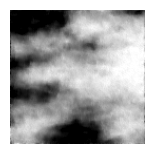

100%|██████████| 1000/1000 [00:19<00:00, 52.37it/s]


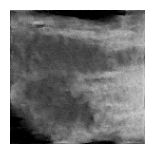

100%|██████████| 1000/1000 [00:19<00:00, 50.66it/s]


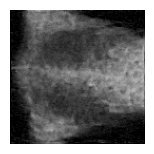

100%|██████████| 1000/1000 [00:19<00:00, 51.96it/s]


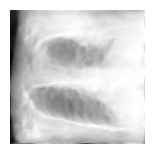

100%|██████████| 1000/1000 [00:19<00:00, 52.49it/s]


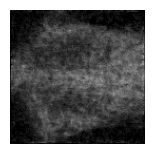

100%|██████████| 1000/1000 [00:19<00:00, 51.23it/s]


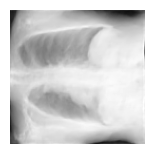

100%|██████████| 1000/1000 [00:20<00:00, 49.62it/s]


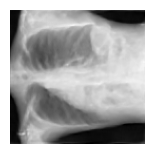

100%|██████████| 1000/1000 [00:20<00:00, 49.30it/s]


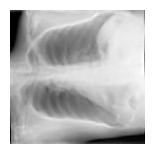

100%|██████████| 1000/1000 [00:20<00:00, 49.85it/s]


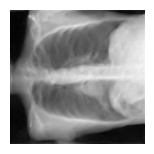

100%|██████████| 1000/1000 [00:19<00:00, 52.39it/s]


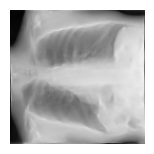

100%|██████████| 1000/1000 [00:19<00:00, 52.59it/s]


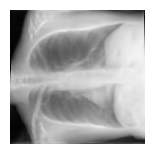

100%|██████████| 1000/1000 [00:19<00:00, 52.14it/s]


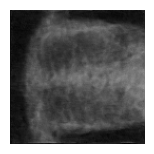

100%|██████████| 1000/1000 [00:19<00:00, 51.29it/s]


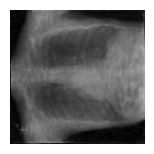

100%|██████████| 1000/1000 [00:19<00:00, 51.73it/s]


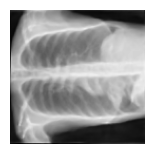

100%|██████████| 1000/1000 [00:19<00:00, 51.59it/s]


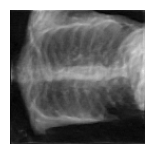

100%|██████████| 1000/1000 [00:19<00:00, 52.02it/s]


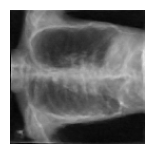

100%|██████████| 1000/1000 [00:19<00:00, 51.23it/s]


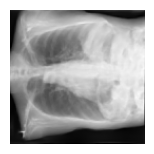

100%|██████████| 1000/1000 [00:19<00:00, 50.91it/s]


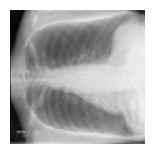

100%|██████████| 1000/1000 [00:19<00:00, 51.56it/s]


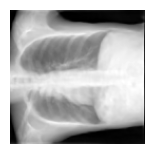

100%|██████████| 1000/1000 [00:19<00:00, 51.19it/s]


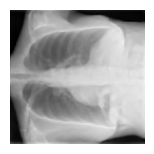

train completed, total time: 1759.978759765625.


In [28]:
use_pretrained = False

if use_pretrained:
    model = torch.hub.load("marksgraham/pretrained_generative_models:v0.2", model="ddpm_2d", verbose=True).to(device)
else:
    n_epochs = 100
    val_interval = 5
    epoch_loss_list = []
    val_epoch_loss_list = []

    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in progress_bar:
            images = batch["image"].to(device)
            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=True):
                # Generate random noise
                noise = torch.randn_like(images).to(device)

                # Create timesteps
                timesteps = torch.randint(
                    0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                ).long()

                # Get model prediction
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

                loss = F.mse_loss(noise_pred.float(), noise.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
        epoch_loss_list.append(epoch_loss / (step + 1))

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_epoch_loss = 0
            for step, batch in enumerate(val_loader):
                images = batch["image"].to(device)
                with torch.no_grad():
                    with autocast(enabled=True):
                        noise = torch.randn_like(images).to(device)
                        timesteps = torch.randint(
                            0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                        ).long()
                        noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                        val_loss = F.mse_loss(noise_pred.float(), noise.float())

                val_epoch_loss += val_loss.item()
                progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))

            # Sampling image during training
            noise = torch.randn((1, 1, 128, 128))
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(enabled=True):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()

    total_time = time.time() - total_start
    print(f"train completed, total time: {total_time}.")

### Learning curves

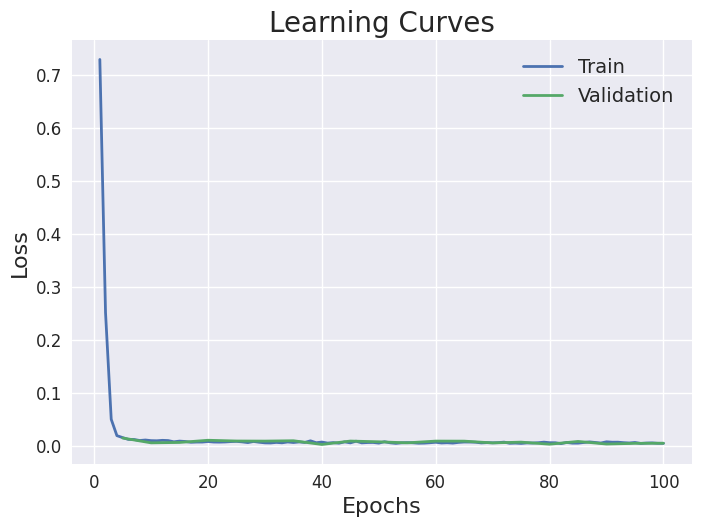

In [29]:
if not use_pretrained:
    plt.style.use("seaborn-v0_8")
    plt.title("Learning Curves", fontsize=20)
    plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
    plt.plot(
        np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
        val_epoch_loss_list,
        color="C1",
        linewidth=2.0,
        label="Validation",
    )
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(prop={"size": 14})
    plt.show()

### Plotting sampling process along DDPM's Markov chain

100%|██████████| 1000/1000 [00:17<00:00, 56.10it/s]


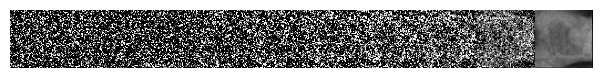

In [30]:
model.eval()
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
with autocast(enabled=True):
    image, intermediates = inferer.sample(
        input_noise=noise, diffusion_model=model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
    )

chain = torch.cat(intermediates, dim=-1)

plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [31]:
if directory is None:
    shutil.rmtree(root_dir)